<h2><center></center></h2>
<h1><center>Neural Network From Scratch</center></h1>
<h4><center>Scroll down for results</center></h4>
<h4><center>TensorFlow is only used to load the DATASET</center></h4>

In [ ]:
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

2024-06-20 14:40:22.854763: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 14:40:22.854797: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 14:40:22.855721: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-20 14:40:22.860861: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-20 14:40:23.421287: W tensorflow/compiler/tf2

In [ ]:
def one_hot(x, depth):
    res=[]
    for i in range(len(x)):
        tmp = [0 for i in range(depth)]
        tmp[x[i]] = 1
        tmp = np.array(tmp)
        res.append(tmp)
    res = np.array(res)
    return res

In [ ]:
(train_data, train_label), (test_data, test_label) =mnist.load_data()

train_data = train_data.reshape((60000, 28*28))
test_data = test_data.reshape((10000, 28*28))

test_label = one_hot(test_label, 10)
train_label = one_hot(train_label, 10)

In [ ]:
train_data = train_data / 255

In [ ]:
class Input():
    def __init__(self, shape):
        self.type = "Input"
        self.shape = shape

    def operate(self, x):
        self.Z = np.array(x, copy=True)
        return self.Z

class Dense():
    def __init__(self, shape, prev):
        self.type = "Dense"
        self.shape = shape
        self.prev = prev
        self.W = np.random.uniform(-.5, .5, size=(self.shape, self.prev.shape))
        self.B = np.random.uniform(-.5, .5,size=self.shape)
        self.grad_W = np.zeros((self.shape, self.prev.shape))
        self.grad_Z = np.zeros(self.prev.shape)
        self.grad_B = np.zeros(shape)

    def operate(self, x):
        self.Z = np.matmul(self.W, x) + self.B
        return relu(self.Z)

    def ret(self, x):
        return self.Z

class Output():
    def __init__(self, shape, prev):
        self.type = "Output"
        self.shape = shape
        self.prev = prev
        self.W = np.random.uniform(-.5, .5, size=(self.shape, self.prev.shape))
        self.B = np.random.uniform(-.5, .5,size=self.shape)
        self.grad_W = np.zeros((self.shape, self.prev.shape))
        self.grad_Z = np.zeros(self.prev.shape)
        self.grad_B = np.zeros(shape)
        self.grad_loss = np.zeros(shape)

    def operate(self, x):
        self.Z = np.matmul(self.W, x) + self.B
        return softmax(self.Z)

    def ret(self, x):
        return self.Z

In [ ]:
def softmax(X):
    Z = X - np.max(X)
    return np.exp(Z)/(np.sum(np.exp(Z), axis=0))

In [ ]:
def relu(x):
    return np.maximum(0,x)

def grad_Z(w, z_curr, z_prev, dz_next, act):        #Calculating dLoss wrt dz_prev
    grad = np.zeros(z_prev.shape)
    if act == "relu":
        for i in range(z_prev.shape[0]):
            for j in range(z_curr.shape[0]):
                if z_curr[j] > 0:                   #coz dReLU/dZ whould be zero
                    grad[i] += dz_next[j]*1*w[j][i]
    elif act == "softmax":
        for i in range(z_prev.shape[0]):
            for j in range(z_curr.shape[0]):
                for k in range(dz_next.shape[0]):
                    if k == j:
                        grad[i] += dz_next[k]*(softmax(z_curr)[k] - (softmax(z_curr)[k])**2)*w[j][i]
                    else:
                        grad[i] += dz_next[k]*(-1 * softmax(z_curr)[j] * softmax(z_curr)[k])*w[j][i]
    return grad

def grad_W(w, z_curr, z_prev, dz_next, act):         # Z = matmul(W,Z_prev) + B
    grad = np.zeros(w.shape)
    if act == "relu":
        for j in range(w.shape[0]):
            if z_curr[j] > 0:                       #coz dReLU/dZ whould be zero
                for i in range(w.shape[1]):
                    grad[j][i] = dz_next[j]*1*z_prev[i]
    elif act == "softmax":
        for j in range(w.shape[0]):
            for i in range(w.shape[1]):
                for k in range(dz_next.shape[0]):
                    if j == k:
                        grad[j][i] += dz_next[k]*(softmax(z_curr)[k] - (softmax(z_curr)[k])**2)*z_prev[i]
                    else:
                        grad[j][i] += dz_next[k]*(-1 * softmax(z_curr)[j] * softmax(z_curr)[k])*z_prev[i]
    return grad

def grad_B(b, z_curr, dz_next, act):
    grad = np.zeros(b.shape)
    if act == "relu":
        for j in range(b.shape[0]):
            if z_curr[j] > 0:                       #coz dReLU/dZ whould be zero
                grad[j] =  dz_next[j] * 1 * 1
    elif act == "softmax":
        for j in range(b.shape[0]):
            for k in range(dz_next.shape[0]):
                if j == k:
                    grad[j] += dz_next[k]*(softmax(z_curr)[k] - (softmax(z_curr)[k])**2)*1
                else:
                    grad[j] += dz_next[k]*(-1 * softmax(z_curr)[j] * softmax(z_curr)[k])*1
    return grad

In [ ]:
w = np.array([[1.,-2.,3.],[4.,-5.,6.]])
z_prev = np.array([1.,-2.,3.])
dz_next = np.array([1.,-1.])
b = np.array([1.,1.])
z_curr = np.matmul(w,z_prev) + b

In [ ]:
grad_B(b, z_curr, dz_next, "softmax")

array([ 3.04599586e-08, -3.04599586e-08])

In [ ]:
class model():
    def __init__(self):
        self.step_size = 0.01
        self.epochs = 2
        self.m = 32

    def make(self, inputs, outputs):
        self.comp_graph = []
        self.input_layer = inputs
        self.output_layer = outputs
        i = outputs
        while i.type != "Input":
            self.comp_graph.append(i)
            i=i.prev

    def fit(self, X, Y):
        Y.flags.writeable = False
        X.flags.writeable = False
        correct_pred = 0

        for i in range(len(X)):
            #forward pass
#             i_copy = i
#             i = i%self.m

            x = self.input_layer.operate(X[i])
            for j in range(-1, -1*len(self.comp_graph)-1, -1):
                x = self.comp_graph[j].operate(x)

            if np.argmax(x) == np.argmax(Y[i]):
                correct_pred += 1

            for e in range(self.epochs):
                #backward pass
                #grad_W(w, z_curr, z_prev, dz_next, act)
                #grad_B(b, z_curr, dz_next, act)
                self.output_layer.grad_loss = (-2)*(Y[i] - softmax(self.output_layer.Z))/len(Y[i])

                self.output_layer.grad_W = grad_W(self.output_layer.W, self.output_layer.Z,
                                                  self.output_layer.prev.Z, self.output_layer.grad_loss, "softmax")

                self.output_layer.grad_Z = grad_Z(self.output_layer.W, self.output_layer.Z,
                                                  self.output_layer.prev.Z, self.output_layer.grad_loss, "softmax")

                self.output_layer.grad_B = grad_B(self.output_layer.B,
                                                  self.output_layer.Z ,self.output_layer.grad_loss, "softmax")

                self.output_layer.W -= self.step_size * self.output_layer.grad_W
                self.output_layer.B -= self.step_size * self.output_layer.grad_B

                self.comp_graph.append(self.comp_graph[-1].prev) #Don't Look Here :-D

                for k in range(1, len(self.comp_graph)-1):
                    self.comp_graph[k].grad_W = grad_W(self.comp_graph[k].W, self.comp_graph[k].Z,
                                                       self.comp_graph[k+1].Z, self.comp_graph[k-1].grad_Z, "relu")

                    self.comp_graph[k].grad_Z = grad_Z(self.comp_graph[k].W, self.comp_graph[k].Z,
                                                       self.comp_graph[k+1].Z, self.comp_graph[k-1].grad_Z, "relu")

                    self.comp_graph[k].grad_B = grad_B(self.comp_graph[k].B,
                                                       self.comp_graph[k].Z, self.comp_graph[k-1].grad_Z, "relu")

                    self.comp_graph[k].W -= self.step_size * self.comp_graph[k].grad_W
                    self.comp_graph[k].B -= self.step_size * self.comp_graph[k].grad_B

                self.comp_graph.pop(-1)                         #Don't Look Here :-D

#             i = i_copy
            if (i%32 == 0):
                print(correct_pred/32, "Total Processed", i)
                correct_pred = 0

    def predict (self, X):
        x = self.input_layer.operate(X)
        for i in range(-1, -1*len(self.comp_graph)-1, -1):
            x = self.comp_graph[i].operate(x)
        return x

In [ ]:
inputs = Input(28*28)
x = Dense(28*2 ,inputs)
outputs = Output(10 ,x)

digit_classifier = model()

In [ ]:
digit_classifier.make(inputs=inputs, outputs=outputs)

In [ ]:
digit_classifier.step_size = 0.1
digit_classifier.epochs = 1
digit_classifier.m = 4
digit_classifier.fit(train_data, train_label)

0.0 Total Processed 0
0.625 Total Processed 32
0.5 Total Processed 64
0.5625 Total Processed 96
0.46875 Total Processed 128
0.53125 Total Processed 160
0.5625 Total Processed 192
0.625 Total Processed 224
0.5625 Total Processed 256
0.71875 Total Processed 288
0.625 Total Processed 320
0.5625 Total Processed 352
0.75 Total Processed 384
0.75 Total Processed 416
0.46875 Total Processed 448
0.6875 Total Processed 480
0.59375 Total Processed 512
0.53125 Total Processed 544
0.71875 Total Processed 576
0.5 Total Processed 608
0.59375 Total Processed 640
0.5625 Total Processed 672
0.6875 Total Processed 704
0.59375 Total Processed 736
0.53125 Total Processed 768
0.5625 Total Processed 800
0.71875 Total Processed 832
0.65625 Total Processed 864
0.6875 Total Processed 896
0.6875 Total Processed 928
0.59375 Total Processed 960
0.625 Total Processed 992
0.5625 Total Processed 1024
0.5625 Total Processed 1056
0.59375 Total Processed 1088
0.4375 Total Processed 1120
0.59375 Total Processed 1152
0.8

KeyboardInterrupt: 

Accuracy: 0.86
3 6 0 0 9 4 6 7 6 8 
0 3 9 0 3 2 2 9 9 0 
6 2 2 4 3 9 7 4 8 2 
2 4 9 5 1 6 9 2 8 1 
1 2 8 2 9 2 8 1 3 9 
0 2 7 6 1 2 0 9 4 3 
7 1 8 6 4 1 7 7 4 0 
6 3 8 4 7 7 1 7 8 2 
0 7 4 3 9 1 1 8 9 3 
6 8 2 0 6 1 9 2 3 2 


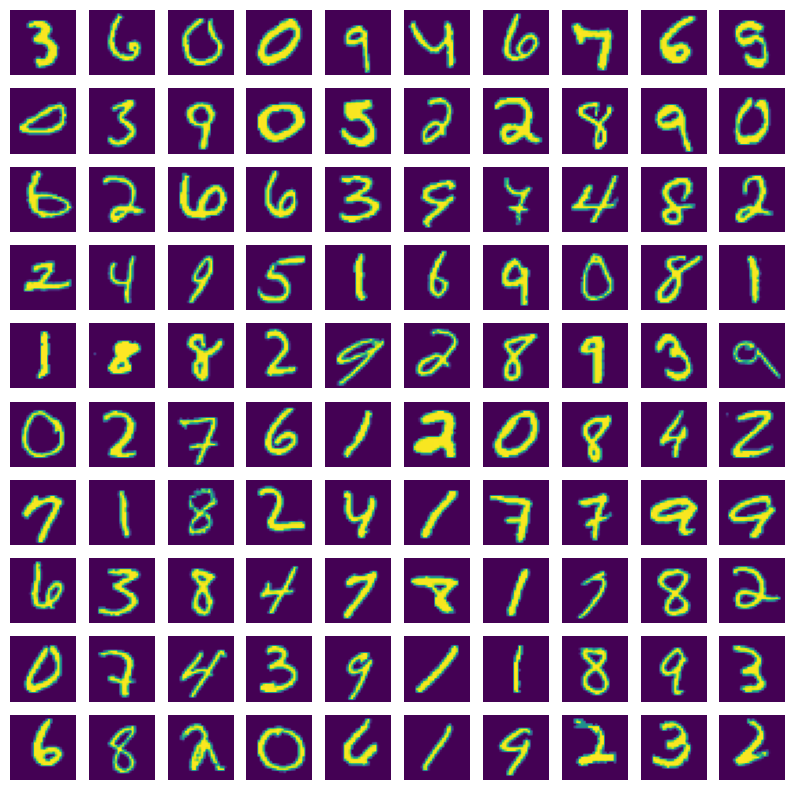

In [ ]:
num_samples = test_data.shape[0]
random_indices = np.random.choice(num_samples, 100, replace=False)

X_sample = test_data[random_indices]
y_sample = test_label[random_indices]
predictions = []
correct_count = 0

plt.figure(figsize=( 10, 10))
for i in range(len(X_sample)):
    ax = plt.subplot(10, 10, i+1)
    plt.imshow((X_sample[i]).reshape((28,28)))
    predictions.append(np.argmax(digit_classifier.predict(X_sample[i])))
    if predictions[i] == np.argmax(y_sample[i]):
        correct_count += 1
    plt.axis("off")

print(f"Accuracy: {correct_count/len(X_sample)}")
for i in range(10):
    for j in range (10):
        print(predictions[10*i+j],end=" ")
    print()


In [ ]:
digit_classifier.comp_graph.pop(-1)